# This notebook is to perform EDA on the mouse TOM files generated by my WGCNA codes vs Laura's WGCNA codes

In [1]:
import sys
sys.path.append("../..")
import pandas as pd
import os
from sys import platform 
prefix = 'G:' if platform == 'win32' else '/Volumes/GoogleDrive'
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [38]:
old_expression_data = pd.read_csv(r'G:\Shared drives\NIAAA_ASSIST\Data\kapoor_expression.txt', sep = '\t')

In [39]:
# Convert new expression data to the same format as the old expression data 
## Re-run WGCNA (my codes) on the new expression data for new TOM file
new_expression_data = pd.read_csv(r'G:\Shared drives\NIAAA_ASSIST\Data\kapoor_expression_Apr5.txt', sep = '\t')
new_expr_T = new_expression_data.T

In [46]:
new_expr_T['id'] = new_expr_T.index

In [48]:
new_expr_T.to_csv(r'G:\Shared drives\NIAAA_ASSIST\Data\kapoor_expression_Apr5_transposed.txt', sep = '\t')

In [3]:
old_tom = pd.read_csv(prefix + '/Shared drives/NIAAA_ASSIST/Data/HDID_data/PFC_tom.csv', index_col = 0)

In [4]:
new_tom = pd.read_csv(prefix + '/Shared drives/NIAAA_ASSIST/Data/pipeline/mouse/network_analysis/YC_Apr8/TOM.csv', index_col = 0)

In [8]:
new_tom.head()

,ILMN_2896528,ILMN_2721178,ILMN_3033922,ILMN_3092673,ILMN_1230777,ILMN_1246069,ILMN_1243193,ILMN_2543688,ILMN_1224596,ILMN_2808939,...,ILMN_2811263,ILMN_2667033,ILMN_2618423,ILMN_2514292,ILMN_2498108,ILMN_2499888,ILMN_2432039,ILMN_2483638,ILMN_2432040,ILMN_2424408
ILMN_2896528,1.000000,0.103248,0.011444,0.128510,0.000023,0.002538,0.000015,0.069380,0.003626,0.000098,...,1.266199e-06,0.122972,0.016445,0.139979,0.001471,0.008949,0.035469,0.120507,0.018687,4.273804e-07
ILMN_2721178,0.103248,1.000000,0.051414,0.066375,0.000120,0.028211,0.000056,0.010958,0.000565,0.001302,...,6.686466e-07,0.062607,0.007435,0.055332,0.000410,0.001311,0.011334,0.044883,0.004930,2.147941e-06
ILMN_3033922,0.011444,0.051414,1.000000,0.004287,0.006640,0.276262,0.002307,0.001002,0.000091,0.033159,...,2.679585e-05,0.002934,0.015339,0.001202,0.000466,0.000112,0.003407,0.001446,0.001098,6.032628e-05
ILMN_3092673,0.128510,0.066375,0.004287,1.000000,0.000014,0.000801,0.000008,0.061503,0.004416,0.000029,...,3.068804e-06,0.137252,0.010442,0.175558,0.001281,0.009894,0.028195,0.147700,0.017089,9.154782e-07
ILMN_1230777,0.000023,0.000120,0.006640,0.000014,1.000000,0.021225,0.019252,0.000007,0.000954,0.072938,...,3.161003e-02,0.000004,0.002117,0.000003,0.002477,0.000338,0.000062,0.000004,0.000350,5.225728e-02


In [10]:
de_data = pd.read_csv(prefix + '/Shared drives/NIAAA_ASSIST/Data/HDID_data/de_data.csv')

In [11]:
de_data.head()

,id,gene,log2FoldChange,padj
0,ILMN_2862111,Hmgn2,1.780745,0.000362
1,ILMN_2634349,Arhgap35,-1.546438,0.000996
2,ILMN_1229634,Usp29,1.502853,0.001677
3,ILMN_2507182,Tomm22,2.220878,0.001849
4,ILMN_2601928,Pnmal1,1.278039,0.002384


In [18]:
from src.eda.eda_functions import *

In [16]:
%%time
old_comm_df1 = run_louvain(old_tom, 1, -1) # default setting
new_comm_df1 = run_louvain(new_tom, 1, -1)

Wall time: 1min 25s


Removing existing folder: output
Created folder output


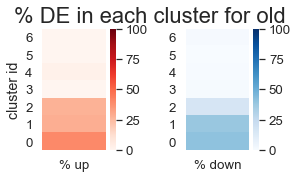

In [19]:
cluster_DE_perc(old_comm_df1, 'louvain_label', 'old', deseq = de_data)

In [23]:
new_comm_df1 = run_louvain(new_tom, 1, 1)

In [25]:
run_louvain(new_tom, 1, 0.2)['louvain_label'].unique().shape

(4,)

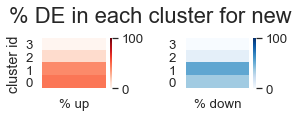

In [22]:
cluster_DE_perc(new_comm_df1, 'louvain_label', 'new', deseq = de_data)

In [28]:
old_critical_gene_df = pd.read_csv(prefix + '/Shared drives/NIAAA_ASSIST/Data/pipeline/mouse/ml_and_critical_gene_identifier/run2/epoch=100_alpha=0.1_critical_gene_df.csv', index_col = 0)

In [26]:
new_critical_gene_df = pd.read_csv(prefix + '/Shared drives/NIAAA_ASSIST/Data/pipeline/mouse/ml_and_critical_gene_identifier/YC_Apr8/epoch=100_alpha=0.1_critical_gene_df.csv', index_col = 0)

In [36]:
len(set(old_critical_gene_df.index).intersection(set(new_critical_gene_df.index[:584])))

29